In [41]:
from os import path, listdir, getcwd

import torch as t
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors

from tqdm import tqdm 

import sys
sys.path.append("../../")
from periodic_padding import periodic_padding

In [2]:
device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

In [3]:
def unfold_conv(batch: t.Tensor) -> t.Tensor:
    unfold_transform = t.nn.Unfold(kernel_size=3)
    # provide a periodic torus padding to the grid
    padded_batch = periodic_padding(batch)
    # we need to add a channel dimension because unfold expects vectors of shape (N,C,H,W)
    padded_batch = padded_batch.unsqueeze(1)
    # apply the unfolding operator on the padded grid, this provides all convolution blocks
    unfolded_batch = unfold_transform(padded_batch)
    # turn each convolution block into a row
    batch_reshaped = unfolded_batch.permute(0, 2, 1)
    return batch_reshaped

In [4]:
def bg_contacts(conv_mat:t.Tensor) -> t.Tensor:
    num_convs = conv_mat.shape[1]
    return t.sum((1 - conv_mat) * conv_mat[:,:,4].T.expand(num_convs, 9))

In [370]:
def grid2gsc(grid, scale_min, scale_max, scale_mean, scale_std):
    min_sampler = t.distributions.Normal(scale_min, scale_std)
    max_sampler = t.distributions.Normal(scale_max, scale_std)
    mean_sampler = t.distributions.Normal(scale_mean, scale_std)
    mask = t.logical_and(grid != 0, grid != 1)
    #print(mask)
    p_vec = grid[mask].unsqueeze(1)
    p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
    #print(p_vec_expanded)
    gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
    #print(gumbel_samples)
    cell_ids = 1 - gumbel_samples[:, 0]
    reconstruction = t.zeros(*grid.shape, device="cpu")
    reconstruction[t.logical_not(mask)] += grid[t.logical_not(mask)]
    reconstruction[mask] += cell_ids
    #reconstruction *= max_sampler.sample(reconstruction.shape)
    #reconstruction[reconstruction == 0] += min_sampler.sample(reconstruction[reconstruction == 0].shape)
    reconstruction *= mean_sampler.sample(reconstruction.shape)
    reconstruction[reconstruction == 0] *= 0
    reconstruction = reconstruction.clamp(0,1)
    return reconstruction

In [99]:
def reconstruction_loss(ref_pic, rec_pic):
    return t.log(t.sum((ref_pic - rec_pic)**2))

In [110]:
def loss_fn(grid, ref_pic):
    conv_mat = unfold_conv(grid)
    rec_pic = grid2gsc(grid, t.min(ref_pic), t.max(ref_pic), t.mean(ref_pic), t.std(ref_pic))
    return bg_contacts(conv_mat)*100000 + reconstruction_loss(ref_pic, rec_pic)

In [101]:
nuclei_path = path.join(getcwd(), "data", "nuclei")
listdir(nuclei_path)

['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552',
 '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1',
 '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
 '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed',
 '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf',
 '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21',
 '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426',
 '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339',
 '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776',
 '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe',
 '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a',
 '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd',
 '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e',
 '05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13',
 '0532c64c2fd0c4d3188cc751cdfd566b

00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png


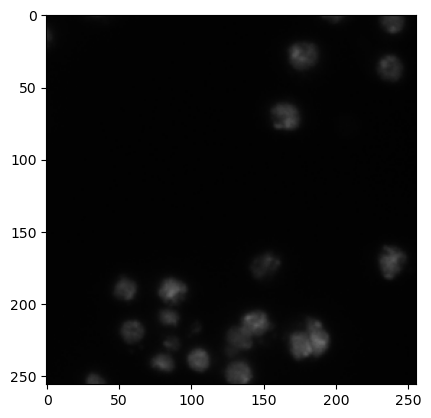

In [102]:
from PIL import Image
input_path = path.join(nuclei_path, listdir(nuclei_path)[0])
print(listdir(path.join(input_path, "images"))[-1])
image_path = path.join(input_path, "images", listdir(path.join(input_path, "images"))[-1])
img = Image.open(image_path)
plt.imshow(img)

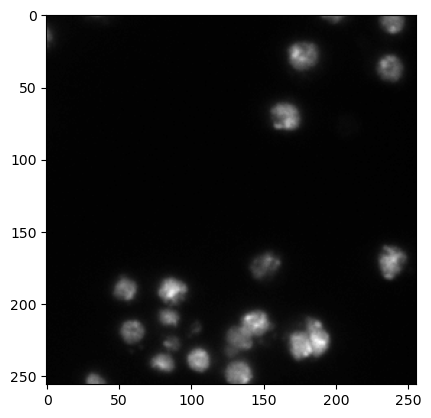

In [103]:
img_gsc = img.convert("L")
plt.imshow(img_gsc, cmap=plt.cm.gray)

[[0.02352941 0.01960784 0.01960784 ... 0.02352941 0.02352941 0.01960784]
 [0.01960784 0.01960784 0.01568627 ... 0.03137255 0.02745098 0.02745098]
 [0.01960784 0.01568627 0.01568627 ... 0.03921569 0.03529412 0.03137255]
 ...
 [0.03137255 0.04313725 0.05490196 ... 0.03137255 0.02352941 0.02352941]
 [0.02745098 0.02745098 0.03137255 ... 0.03137255 0.02352941 0.01960784]
 [0.01960784 0.02352941 0.02352941 ... 0.03137255 0.02352941 0.01960784]]


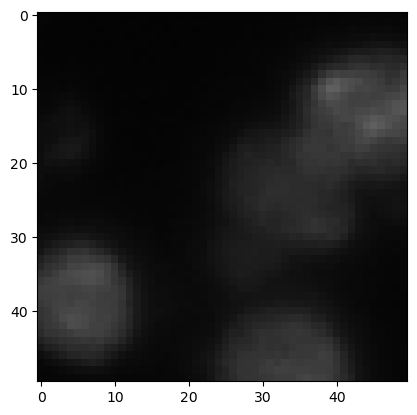

In [104]:
snippet = np.asarray(img_gsc)[200:250, 100:150]/255
print(snippet)
plt.imshow(snippet, cmap=plt.cm.gray, vmin=0, vmax=1)

In [105]:
grid = t.zeros_like(t.tensor(snippet))
grid = grid.unsqueeze(0)
ref = t.from_numpy(snippet)
ref = ref.unsqueeze(0)
max_intensity = t.max(ref)
min_intensity = t.min(ref)
mean_intensity = t.mean(ref)
std_intensity = t.std(ref)

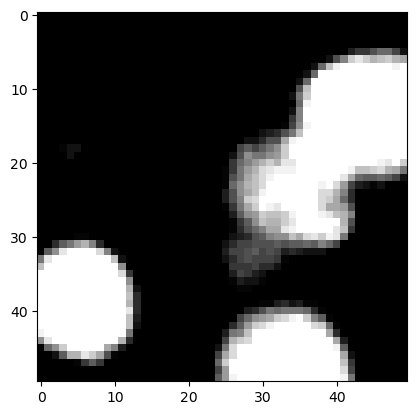

In [106]:
centering = transforms.Normalize(mean_intensity, std_intensity)
ref_centered = centering(ref)
plt.imshow(ref_centered[0], cmap=plt.cm.gray, vmin=0, vmax=1)

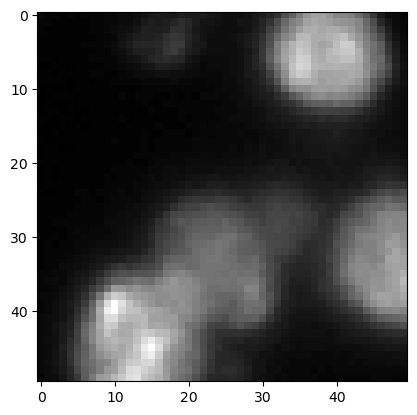

In [107]:
center2 = (ref_centered - t.min(ref_centered)) / (t.max(ref_centered) - (t.min(ref_centered))) 
plt.imshow(center2[0].T, cmap=plt.cm.gray, vmin=0, vmax=1)

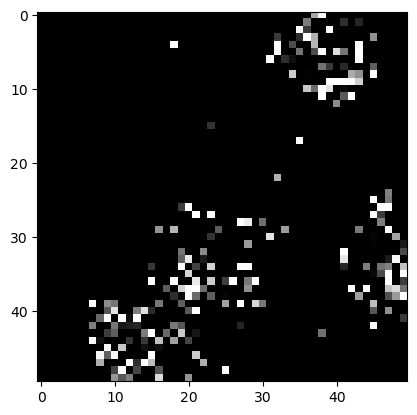

In [108]:
test_rec = grid2gsc(center2, t.min(ref_centered), t.max(ref_centered), t.mean(ref_centered), t.std(ref_centered))
plt.imshow(test_rec.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

In [111]:
center2.requires_grad_()
for i in tqdm(range(1000)):
    loss = loss_fn(center2, ref_centered)
    grads = t.autograd.grad(loss, center2)[0]
    center2 = t.clamp(center2 - 0.001 * grads, min=0, max=1)

100%|██████████| 1000/1000 [00:04<00:00, 230.74it/s]


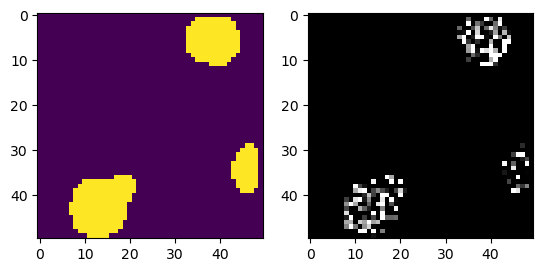

In [113]:
mask = t.logical_and(center2 != 0, center2 != 1)
#print(mask)
p_vec = center2[mask].unsqueeze(1)
p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
#print(p_vec_expanded)
gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
#print(gumbel_samples)
cell_ids = 1 - gumbel_samples[:, 0]
reconstruction = t.zeros(*center2.shape, device="cpu")
reconstruction[t.logical_not(mask)] += center2[t.logical_not(mask)]
reconstruction[mask] += cell_ids
fig, axs = plt.subplots(1,2)
axs[0].imshow(reconstruction.T.detach().squeeze().numpy())
test_rec = grid2gsc(center2, t.min(ref_centered), t.max(ref_centered), t.mean(ref_centered), t.std(ref_centered))
axs[1].imshow(test_rec.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

# KNN

In [24]:
def euclid_dist(c1, c2):
    return t.sqrt(t.sum((c1-c2)**2))

def get_label(c1, centroids):
    best_label = None
    best_dist = float("inf")
    for idx, centroid in enumerate(centroids):
        dist = euclid_dist(c1, centroid)
        #print(dist)
        if dist <= best_dist:
            best_label = idx+1
            best_dist = dist
    return best_label

def calc_centroid(points):
    #print(points.shape)
    return t.concat([t.floor(t.mean(points[:,1].type(t.float))).unsqueeze(0), t.floor(t.mean(points[:,2].type(t.float))).unsqueeze(0)])

In [459]:
def kmeans(num_iter, num_classes, grid, visualize=False):
    xs = t.randint(0, grid.shape[-1], size=(num_classes,))
    ys = t.randint(0, grid.shape[-2], size=(num_classes,))
    centroids = t.hstack((xs.unsqueeze(1), ys.unsqueeze(1)))
    print(centroids.shape)
    
    for step in tqdm(range(num_iter)):
        points = (grid > 0).nonzero()
        for idx in range(points.shape[0]):
            cur = points[idx,1:]
            label = get_label(cur, centroids)
            grid[0, cur[0], cur[1]] = label
        for centroid_idx in range(centroids.shape[0]):
            members = (grid == (centroid_idx+1)).nonzero()
            centroids[centroid_idx] = calc_centroid(members)
        if visualize:
            fig, axs = plt.subplots()
            scheme = ["black", 'b','y','g','r']
            cmap = colors.ListedColormap(scheme)
            axs.imshow(grid.T.detach().squeeze().numpy(), cmap=cmap)
            plt.gca().invert_yaxis()
            for j in range (centroids.shape[0]):
                axs.scatter(centroids[j,0], centroids[j,1], color=[scheme[j+1]])
    return grid, centroids
            
labeled_rec = reconstruction.detach().clone()
labeled_rec, centroids = kmeans(500, 3, labeled_rec)

torch.Size([3, 2])


100%|██████████| 500/500 [01:37<00:00,  5.13it/s]


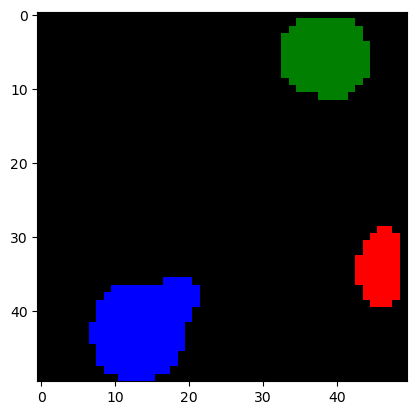

In [30]:
fig, axs = plt.subplots()
scheme = ["black", 'b','y','g','r']
cmap = colors.ListedColormap(scheme)
axs.imshow(labeled_rec.T.detach().squeeze().numpy(), cmap=cmap)

# Test 2: using the full image

In [114]:
test_img = np.asarray(img_gsc)/255
grid = t.zeros_like(t.tensor(test_img))
grid = grid.unsqueeze(0)
ref = t.from_numpy(test_img)
ref = ref.unsqueeze(0)
max_intensity = t.max(ref)
min_intensity = t.min(ref)
mean_intensity = t.mean(ref)
std_intensity = t.std(ref)

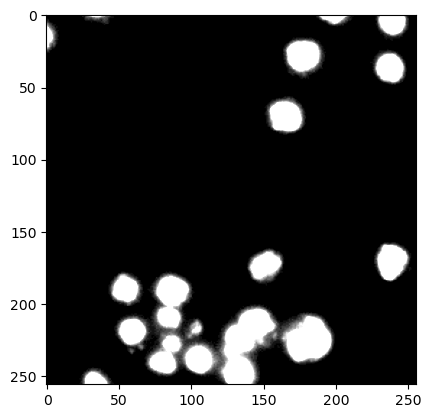

In [115]:
centering = transforms.Normalize(mean_intensity, std_intensity)
ref_centered = centering(ref)
plt.imshow(ref_centered[0], cmap=plt.cm.gray, vmin=0, vmax=1)

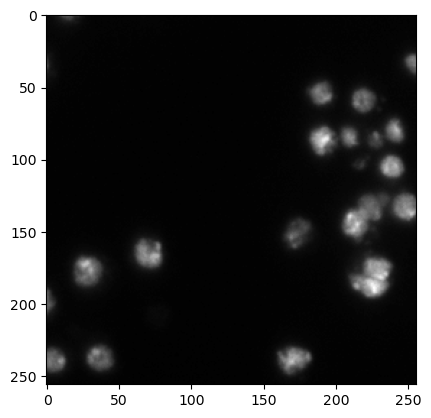

In [236]:
center2 = (ref_centered - t.min(ref_centered)) / (t.max(ref_centered) - (t.min(ref_centered))) 
plt.imshow(center2[0].T, cmap=plt.cm.gray, vmin=0, vmax=1)

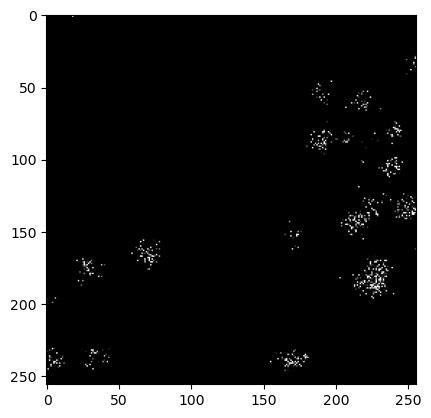

In [237]:
test_rec = grid2gsc(center2, t.min(ref_centered), t.max(ref_centered), t.mean(ref_centered), t.std(ref_centered))
plt.imshow(test_rec.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

In [371]:
def bg_contacts(conv_mat:t.Tensor) -> t.Tensor:
    #print((9 - t.sum(conv_mat, dim=-1)).squeeze().shape)
    #print(conv_mat[:,:,4].shape)
    return t.sum( (9 - t.sum(conv_mat, dim=-1)).squeeze() * conv_mat[:,:,4])

In [395]:
def loss_fn(grid, ref_pic):
    rec_pic = grid2gsc(grid, t.min(ref_pic), t.max(ref_pic), t.mean(ref_pic), t.std(ref_pic))
    #print(rec_pic)
    conv_mat = unfold_conv(center2)
    #plt.imshow(rec_pic.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
    #print(bg_contacts(conv_mat)*0.1)
    #print(reconstruction_loss(ref_pic, rec_pic))
    return bg_contacts(conv_mat)*0.01 + reconstruction_loss(ref_pic, rec_pic)

In [396]:
center2 = (ref_centered - t.min(ref_centered)) / (t.max(ref_centered) - (t.min(ref_centered)))
start_state = center2.detach().clone()

In [407]:
center2.requires_grad_()
for i in tqdm(range(1_000)):
    loss = loss_fn(center2, ref_centered)
    grads = t.autograd.grad(loss, center2)[0]
    center2 = t.clamp(center2 - 0.001 * grads, min=0, max=1)

100%|██████████| 1000/1000 [00:37<00:00, 26.68it/s]


(-0.5, 255.5, 255.5, -0.5)

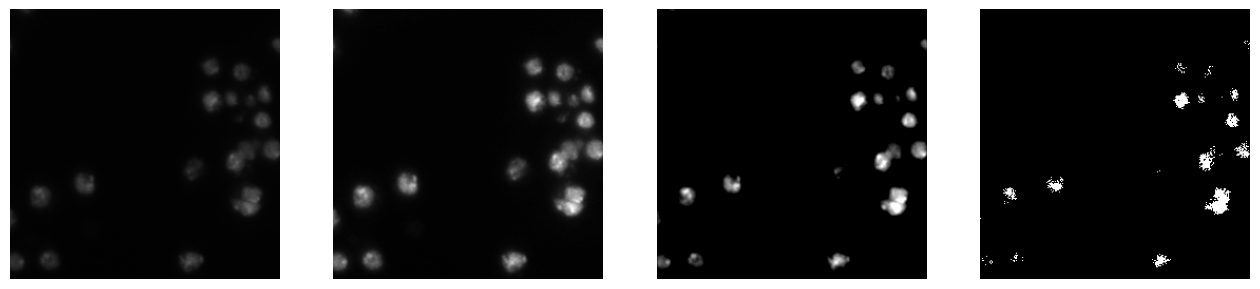

In [408]:
mask = t.logical_and(center2 != 0, center2 != 1)
#print(mask)
p_vec = center2[mask].unsqueeze(1)
p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
#print(p_vec_expanded)
gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
#print(gumbel_samples)
cell_ids = 1 - gumbel_samples[:, 0]
reconstruction = t.zeros(*center2.shape, device="cpu")
reconstruction[t.logical_not(mask)] += center2[t.logical_not(mask)]
reconstruction[mask] += cell_ids
fig, axs = plt.subplots(1,4, figsize=(16,10))
axs[0].imshow(test_img.T, cmap=plt.cm.gray, vmin=0, vmax=1)
axs[0].axis("off")
axs[1].imshow(start_state.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[1].axis("off")
axs[2].imshow(center2.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[2].axis("off")
axs[3].imshow(reconstruction.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[3].axis("off")

(-0.5, 255.5, 255.5, -0.5)

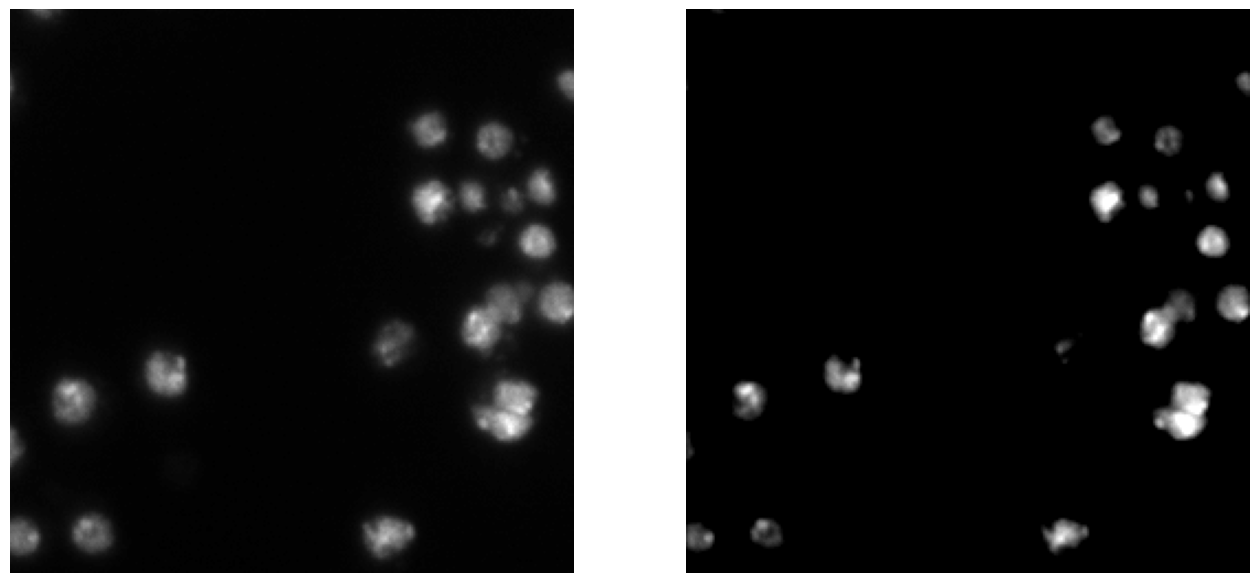

In [409]:
fig, axs = plt.subplots(1,2, figsize=(16,10))
axs[0].imshow(start_state.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[0].axis("off")
axs[1].imshow(center2.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[1].axis("off")

(-0.5, 255.5, 255.5, -0.5)

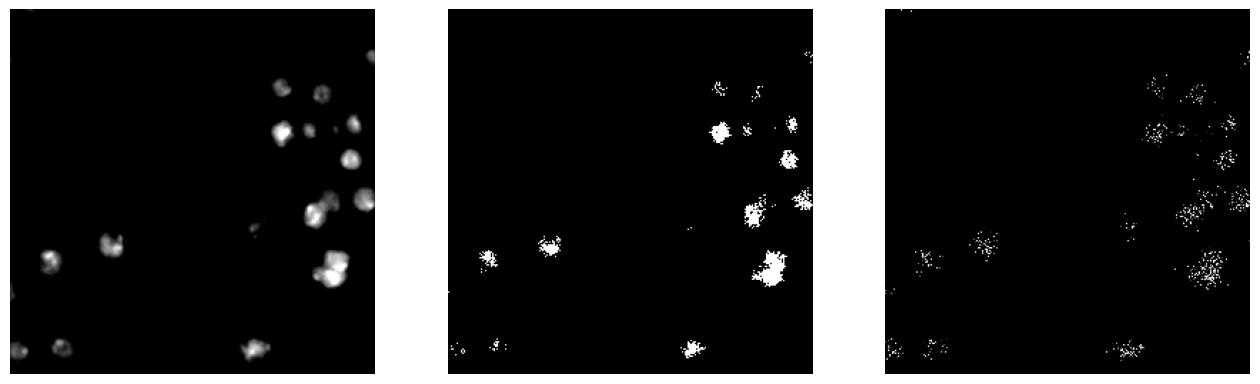

In [410]:
fig, axs = plt.subplots(1,3, figsize=(16,10))
axs[0].imshow(center2.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[0].axis("off")
axs[1].imshow(reconstruction.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[1].axis("off")
axs[2].imshow(test_rec.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[2].axis("off")

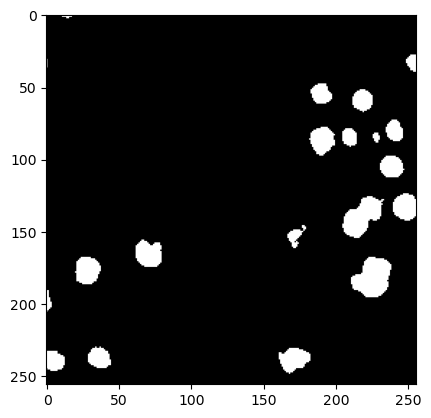

In [411]:
thres_img = center2.detach().clone()
thres_img[center2>0] = 1
plt.imshow(thres_img.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

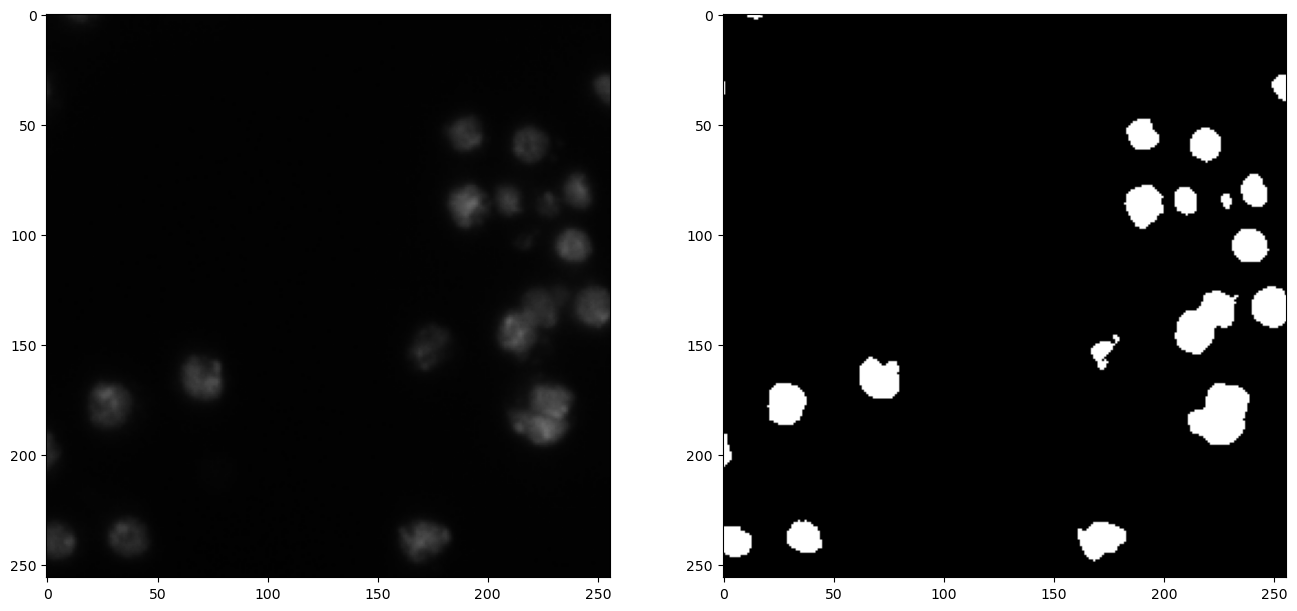

In [412]:
fig, axs = plt.subplots(1,2, figsize=(16,10))
axs[0].imshow(test_img.T, cmap=plt.cm.gray, vmin=0, vmax=1)
axs[1].imshow(thres_img.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

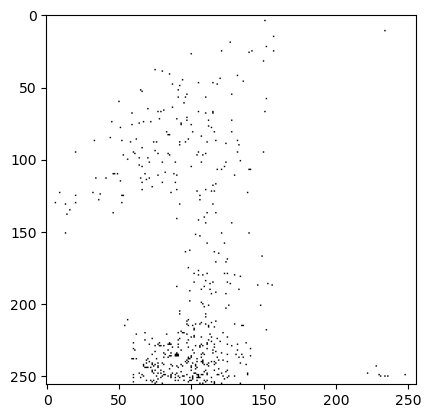

In [413]:
thres2 = start_state.detach().clone()
thres2[start_state>0] = 1
plt.imshow(thres2.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

# Test 3: Use a different image

0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed.png


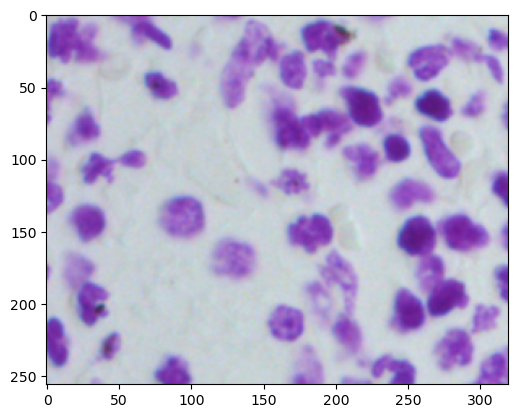

In [419]:
input_path = path.join(nuclei_path, listdir(nuclei_path)[3])
print(listdir(path.join(input_path, "images"))[0])
image_path = path.join(input_path, "images", listdir(path.join(input_path, "images"))[-1])
img = Image.open(image_path)
plt.imshow(img)

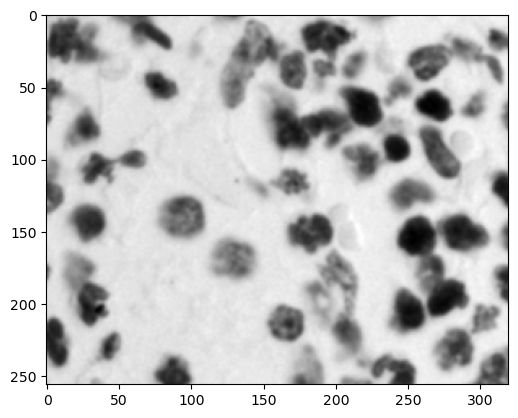

In [420]:
img_gsc = img.convert("L")
plt.imshow(img_gsc, cmap=plt.cm.gray)

In [421]:
test_img = np.asarray(img_gsc)/255
grid = t.zeros_like(t.tensor(test_img))
grid = grid.unsqueeze(0)
ref = t.from_numpy(test_img)
ref = ref.unsqueeze(0)
max_intensity = t.max(ref)
min_intensity = t.min(ref)
mean_intensity = t.mean(ref)
std_intensity = t.std(ref)

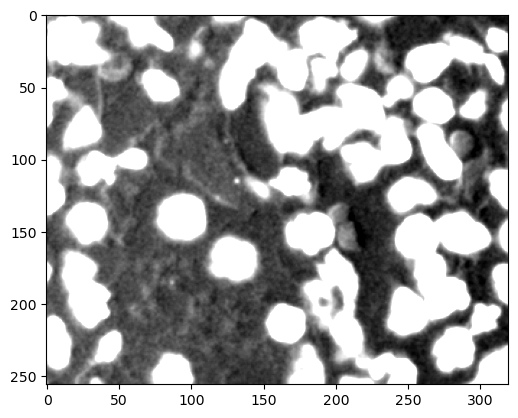

In [423]:
centering = transforms.Normalize(mean_intensity, std_intensity)
ref_centered = (1-centering(ref))
plt.imshow(ref_centered[0], cmap=plt.cm.gray, vmin=0, vmax=1)

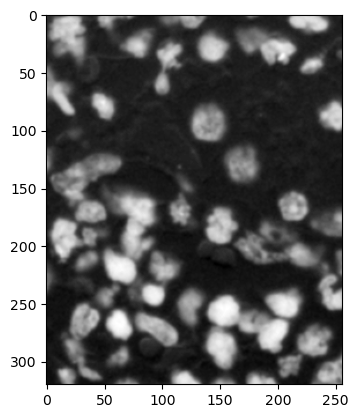

In [426]:
center2 = (ref_centered - t.min(ref_centered)) / (t.max(ref_centered) - (t.min(ref_centered))) 
plt.imshow(center2[0].T, cmap=plt.cm.gray, vmin=0, vmax=1)

In [443]:
def loss_fn(grid, ref_pic):
    rec_pic = grid2gsc(grid, t.min(ref_pic), t.max(ref_pic), t.mean(ref_pic), t.std(ref_pic))
    #print(rec_pic)
    conv_mat = unfold_conv(center2)
    #plt.imshow(rec_pic.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
    #print(bg_contacts(conv_mat)*0.1)
    #print(reconstruction_loss(ref_pic, rec_pic))
    return bg_contacts(conv_mat)*0.05 + reconstruction_loss(ref_pic, rec_pic)

In [444]:
center2 = (ref_centered - t.min(ref_centered)) / (t.max(ref_centered) - (t.min(ref_centered)))
start_state = center2.detach().clone()

In [445]:
center2.requires_grad_()
for i in tqdm(range(2_000)):
    loss = loss_fn(center2, ref_centered)
    grads = t.autograd.grad(loss, center2)[0]
    center2 = t.clamp(center2 - 0.001 * grads, min=0, max=1)

100%|██████████| 2000/2000 [01:35<00:00, 20.94it/s]


(-0.5, 255.5, 319.5, -0.5)

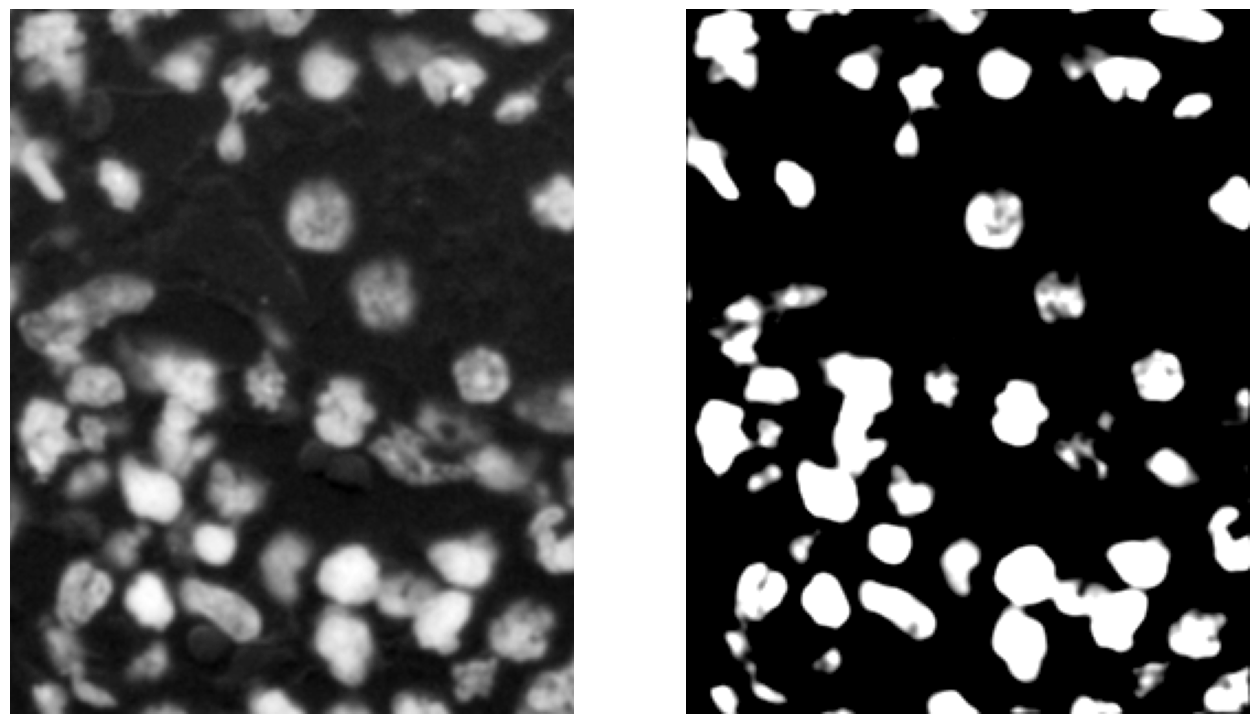

In [446]:
fig, axs = plt.subplots(1,2, figsize=(16,10))
axs[0].imshow(start_state.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[0].axis("off")
axs[1].imshow(center2.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)
axs[1].axis("off")

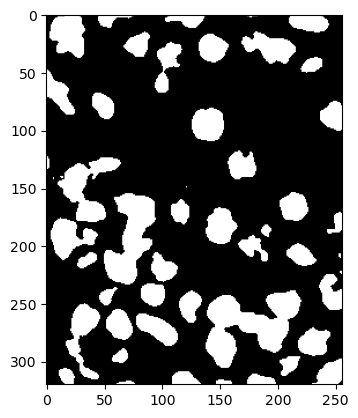

In [447]:
thres_img = center2.detach().clone()
thres_img[center2>0] = 1
#thres_img[center2<0.999] = 0
plt.imshow(thres_img.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

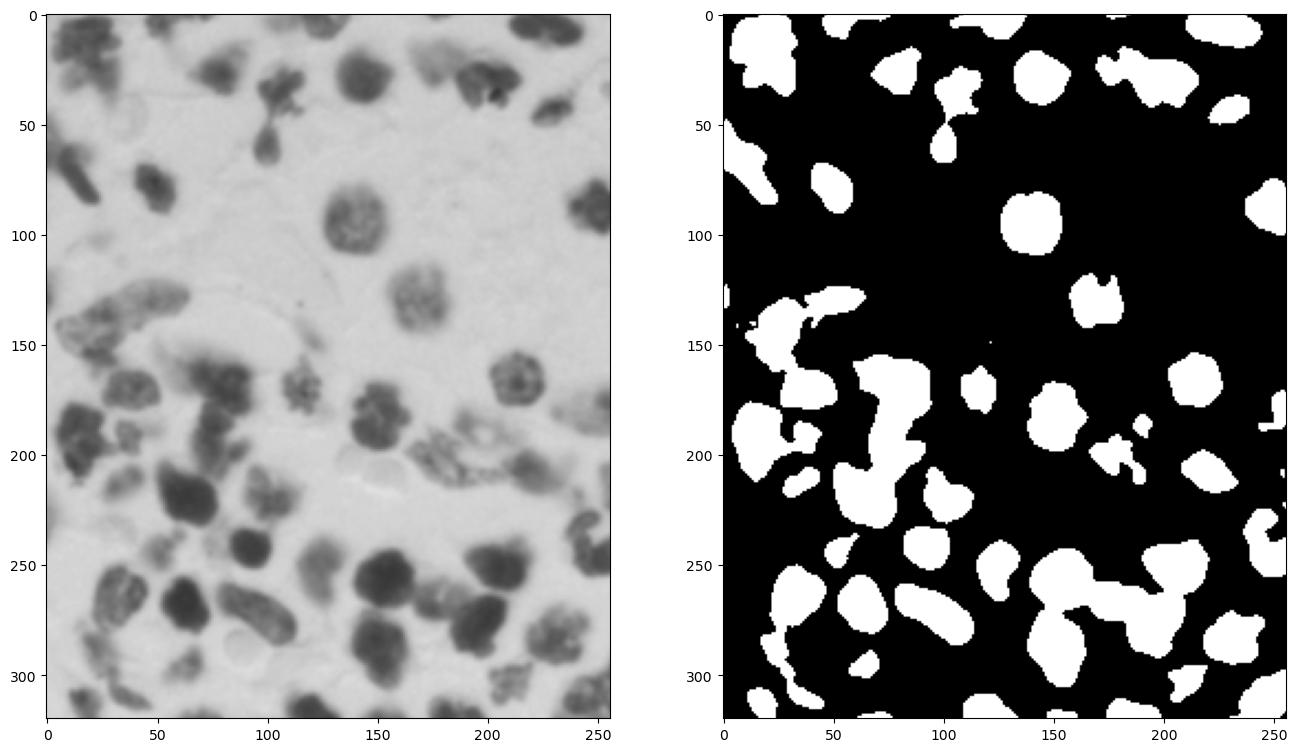

In [448]:
fig, axs = plt.subplots(1,2, figsize=(16,10))
axs[0].imshow(test_img.T, cmap=plt.cm.gray, vmin=0, vmax=1)
axs[1].imshow(thres_img.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)

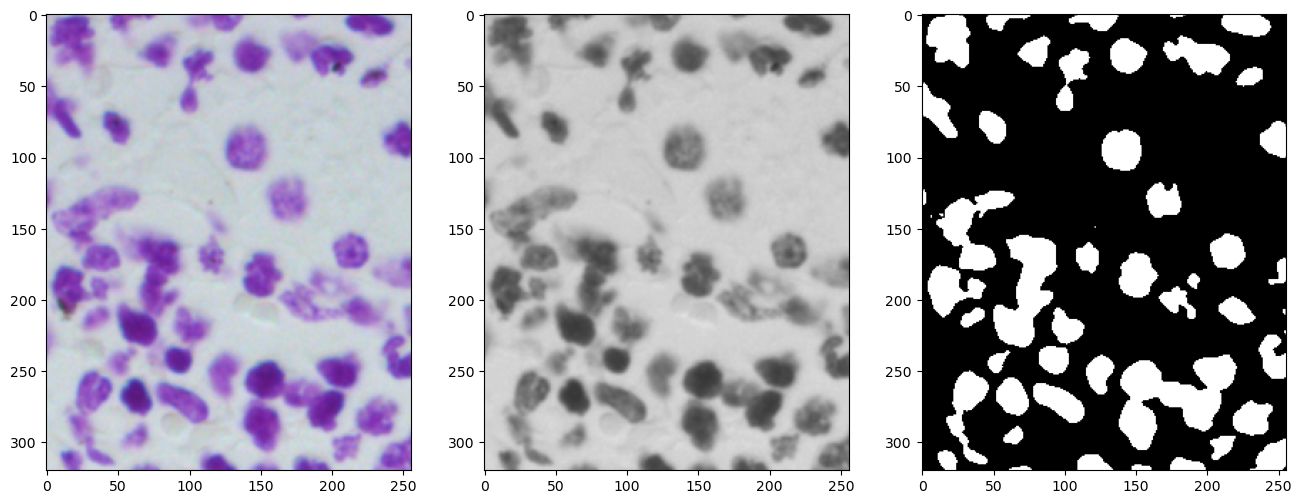

In [454]:
img_as_np = np.asarray(img)
fig, axs = plt.subplots(1,3, figsize=(16,10))
axs[0].imshow(np.swapaxes(img_as_np,0,1))
axs[1].imshow(test_img.T, cmap=plt.cm.gray, vmin=0, vmax=1)
axs[2].imshow(thres_img.T.detach().squeeze().numpy(), cmap=plt.cm.gray, vmin=0, vmax=1)


In [462]:
labeled_grid = thres_img.detach().clone()
labeled_grid, centroids = kmeans(10, 30, thres_img)

torch.Size([30, 2])


100%|██████████| 10/10 [02:58<00:00, 17.85s/it]


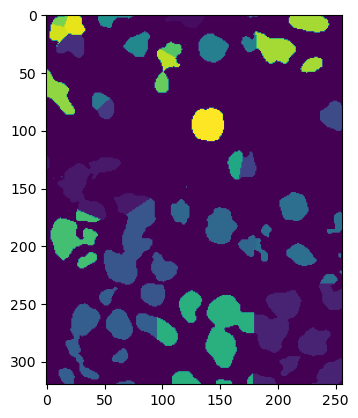

In [478]:
plt.imshow(labeled_grid.T.detach().clone().numpy())

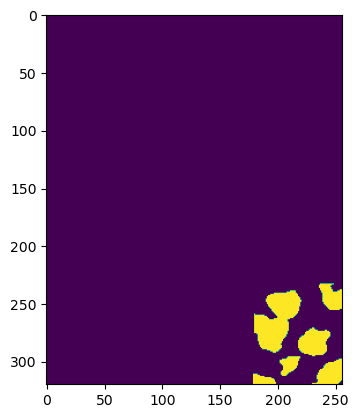

In [477]:
test = labeled_grid.detach().clone().numpy()
test[test != 3] = 0
plt.imshow(test.T)